**Importing the required Libraries**

In [1]:
pip install tensorflow

In [2]:
pip install --upgrade tensorflow

In [3]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Cats_Dogs/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Cats_Dogs/train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 557 files belonging to 2 classes.
Using 446 files for training.
Found 557 files belonging to 2 classes.
Using 111 files for validation.


**Plotting images of first training batch**

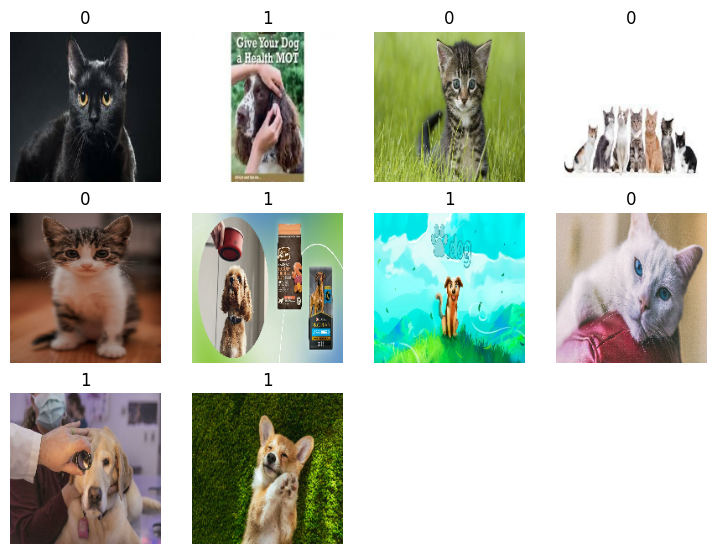

In [6]:

plt.figure(figsize=(9, 9))
for images, labels in train_ds.take(1):
    for i in range(10):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
# Define data augmentation layers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])


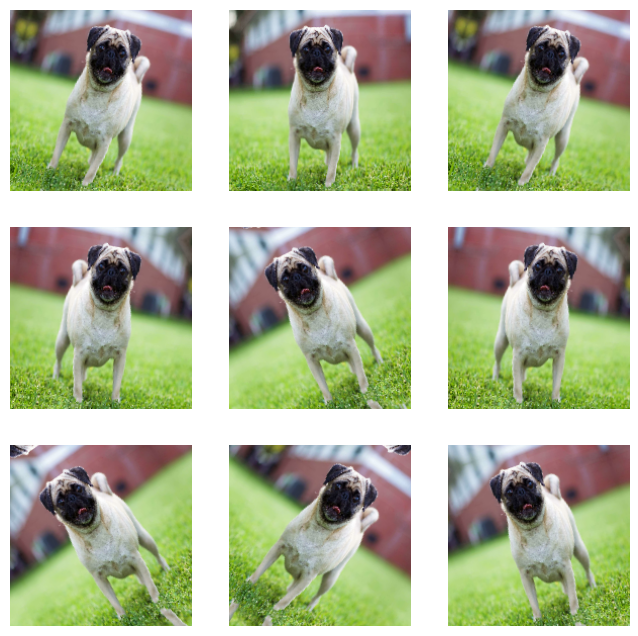

In [8]:
plt.figure(figsize=(8, 8))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [9]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [10]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [11]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [12]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [13]:
epochs =9
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)

Epoch 1/9
14/14 ━━━━━━━━━━━━━━━━━━━━ 191s 12s/step - accuracy: 0.5685 - loss: 0.8434 - val_accuracy: 0.4865 - val_loss: 0.6957
Epoch 2/9
14/14 ━━━━━━━━━━━━━━━━━━━━ 172s 10s/step - accuracy: 0.5573 - loss: 0.7489 - val_accuracy: 0.4865 - val_loss: 0.6975
Epoch 3/9
14/14 ━━━━━━━━━━━━━━━━━━━━ 152s 11s/step - accuracy: 0.6697 - loss: 0.6545 - val_accuracy: 0.4865 - val_loss: 0.6994
Epoch 4/9
14/14 ━━━━━━━━━━━━━━━━━━━━ 149s 11s/step - accuracy: 0.6617 - loss: 0.6463 - val_accuracy: 0.4865 - val_loss: 0.7008
Epoch 5/9
14/14 ━━━━━━━━━━━━━━━━━━━━ 213s 11s/step - accuracy: 0.6472 - loss: 0.6766 - val_accuracy: 0.4865 - val_loss: 0.7006
Epoch 6/9
14/14 ━━━━━━━━━━━━━━━━━━━━ 191s 10s/step - accuracy: 0.6221 - loss: 0.6889 - val_accuracy: 0.4865 - val_loss: 0.7045
Epoch 7/9
14/14 ━━━━━━━━━━━━━━━━━━━━ 205s 11s/step - accuracy: 0.6235 - loss: 0.6709 - val_accuracy: 0.4865 - val_loss: 0.7023
Epoch 8/9
14/14 ━━━━━━━━━━━━━━━━━━━━ 208s 11s/step - accuracy: 0.6235 - loss: 0.6931 - val_accuracy: 0.4865 - v

In [46]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/Cats_Dogs/Testing/cats/cats (57).jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
This image is 60.03 percent cat and 39.97 percent dog.


<ipython-input-46-dddea009c006>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "This image is %.2f percent cat and %.2f percent dog."


In [65]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/Cats_Dogs/Testing/Dogs/dog (9).jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 1)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * score, 100 * (1 - score))
)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
This image is 40.79 percent cat and 59.21 percent dog.


<ipython-input-65-11ac86e1625b>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "This image is %.2f percent cat and %.2f percent dog."


In [24]:
image_size = (180, 180)
batch_size = 32

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Cats_Dogs/test",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

Found 140 files belonging to 2 classes.


In [26]:
test_loss, test_accuracy = model.evaluate(test_ds)


5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7127 - loss: 0.6321
